In [1]:
class TicTacToe:
    def __init__(self):
        # Initialise an empty board
        self.board = ['-' for _ in range(9)]
        self.current_player = 'X'  # X will start
    
    def make_move(self, position):
        """Make a move on the board."""
        if self.board[position] == '-':
            self.board[position] = self.current_player
            self.switch_player()
            return True
        else: return False  # illegal move
    
    def switch_player(self):
        """Switch the current player."""
        self.current_player = 'O' if self.current_player == 'X' else 'X'
    
    def check_winner(self):
        """Check if there is a winner."""
        # Rows, columns, diagonals
        winning_positions = [
            [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
            [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
            [0, 4, 8], [2, 4, 6]  # Diagonals
        ]
        
        for positions in winning_positions:
            values = [self.board[pos] for pos in positions]
            if values[0] == values[1] == values[2] and values[0] != '-':
                return values[0]
        
        return None  # No winner yet
    
    def is_draw(self):
        """Check if the game is a draw."""
        return all(cell != '-' for cell in self.board)
    
    def get_board_string(self):
        """Get the current board state as a string."""
        return ''.join(self.board)
    
    def get_legal_moves(self):
        """Get the positions of all legal moves."""
        return [i for i, cell in enumerate(self.board) if cell == '-']
    
    def pretty_print_board(self):
        """Pretty-print the board."""
        for i in range(0, 9, 3):
            print(f"{self.board[i]} | {self.board[i+1]} | {self.board[i+2]}")
            if i < 6:
                print("- "*5)

# Test the pretty_print_board method
tic_tac_toe = TicTacToe()
print("Initial board:")
tic_tac_toe.pretty_print_board()

# Make some moves
tic_tac_toe.make_move(0)
tic_tac_toe.make_move(4)
tic_tac_toe.make_move(8)
print("\nBoard after some moves:")
tic_tac_toe.pretty_print_board()

Initial board:
- | - | -
- - - - - 
- | - | -
- - - - - 
- | - | -

Board after some moves:
X | - | -
- - - - - 
- | O | -
- - - - - 
- | - | X


In [2]:
from copy import deepcopy
from tqdm import tqdm
import torch.nn as nn
import torch
import torch.nn.functional as F

# Helper function to find if there's a winning move or a move that blocks the opponent from winning
def find_winning_or_blocking_move(board, player):
    winning_positions = [
        [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
        [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
        [0, 4, 8], [2, 4, 6]  # Diagonals
    ]
    for positions in winning_positions:
        values = [board[pos] for pos in positions]
        if values.count(player) == 2 and values.count('-') == 1:
            return positions[values.index('-')]
    return None

# Helper function for checking for fork opportunities
def find_fork_move(board, player):
    fork_move = None
    for i in range(9):
        if board[i] == '-':
            temp_board = board[:]
            temp_board[i] = player
            winning_moves = 0
            for j in range(9):
                if temp_board[j] == '-':
                    temp_board_2 = temp_board[:]
                    temp_board_2[j] = player
                    if find_winning_or_blocking_move(temp_board_2, player) is not None:
                        winning_moves += 1
            if winning_moves >= 2:
                fork_move = i
                break
    return fork_move

# Helper function to find the optimal move according to a defined strategy
def optimal_strategy(board, player):
    opponent = 'O' if player == 'X' else 'X'
    
    # 1. Win: If you have two in a row, play the third to get three in a row.
    win_move = find_winning_or_blocking_move(board, player)
    if win_move is not None:
        return win_move
    
    # 2. Block: If the opponent has two in a row, play the third to block them.
    block_move = find_winning_or_blocking_move(board, opponent)
    if block_move is not None:
        return block_move
    
    # 3. Fork: Create an opportunity where you can win in two ways.
    fork_move = find_fork_move(board, player)
    if fork_move is not None:
        return fork_move
    
    # 4. Block Opponent's Fork
    opponent_fork_move = find_fork_move(board, opponent)
    if opponent_fork_move is not None:
        return opponent_fork_move
    
    # 5. Center: Play the center.
    if board[4] == '-':
        return 4
    
    # 6. Opposite Corner: If the opponent is in the corner, play the opposite corner.
    corners = [(0, 8), (2, 6), (8, 0), (6, 2)]
    for corner1, corner2 in corners:
        if board[corner1] == opponent and board[corner2] == '-':
            return corner2
    
    # 7. Empty Corner: Play an empty corner.
    for corner in [0, 2, 6, 8]:
        if board[corner] == '-':
            return corner
    
    # 8. Empty Side: Play an empty side.
    for side in [1, 3, 5, 7]:
        if board[side] == '-':
            return side

# Function to simulate all games according to the optimal strategy
def simulate_all_games_optimal_v2(game, x_starts=True):
    global input_sequences, output_sequences
    
    # Check for terminal state
    winner = game.check_winner()
    if winner or game.is_draw():
        return
    
    # If it's X's turn, apply the optimal strategy and save the board state and move
    if game.current_player == 'X':
        move = optimal_strategy(game.board, 'X')
        if move is None:
            move = game.get_legal_moves()[0]  # fallback
        input_sequences.append(encode(''.join(game.board)))
        output_sequences.append(move)
        new_game = deepcopy(game)
        new_game.make_move(move)
        simulate_all_games_optimal_v2(new_game, x_starts)
    else:
        # If it's O's turn, explore all possible legal moves
        for move in game.get_legal_moves():
            new_game = deepcopy(game)
            new_game.make_move(move)
            simulate_all_games_optimal_v2(new_game, x_starts)

# Character to integer mapping
chars = sorted(list(set('XO-')))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {0: '-', 1: 'X', 2: 'O'}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Reset and re-simulate
input_sequences = []
output_sequences = []

# 'X' starts
initial_game = TicTacToe()
simulate_all_games_optimal_v2(initial_game, True)
print("Number of input-output pairs:", len(input_sequences))

# 'O' starts
initial_game = TicTacToe()
initial_game.current_player = 'O'
simulate_all_games_optimal_v2(initial_game, False)

# Convert to Pytorch tensors
input_tensor = torch.tensor(input_sequences, dtype=torch.long)
output_tensor = torch.tensor(output_sequences, dtype=torch.long)

print("Number of input-output pairs:", len(input_sequences))

Number of input-output pairs: 170
Number of input-output pairs: 1017


In [3]:
input_tensor[500]

tensor([2, 0, 1, 0, 1, 2, 2, 1, 1])

In [4]:
# Hyperparameters
batch_size = 128  # How many independent sequences will we process in parallel?
block_size = 9  # The size of the tic-tac-toe board
max_iters = 10000
eval_interval = 500
learning_rate = 1e-3
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
eval_iters = 100
n_embd = 32  # Reduced the embedding size
n_head = 2  # Reduced the number of heads
n_layer = 2  # Reduced the number of layers
dropout = 0.1

print(f'Training on {device}')

# Initialize random seed
torch.manual_seed(1337)

# Split into training and validation sets
n = int(0.90 * len(input_tensor))  # 90% for training
train_input = input_tensor[:n]
train_output = output_tensor[:n]
val_input = input_tensor[n:]
val_output = output_tensor[n:]

# Updated data loading function
def get_batch(split):
    input_data = train_input if split == 'train' else val_input
    output_data = train_output if split == 'train' else val_output
    # Choose index locs for batch_size sequences
    ix = torch.randint(len(input_data) - block_size + 1, (batch_size,))
    # Get the input and output sequences
    x = input_data[ix]
    y = output_data[ix]
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class Transformer(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, 9)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x)  # (B,T,C)
        x = self.ln_f(x)  # (B,T,C)
        logits = self.lm_head(x)  # (B,T,vocab_size)
        # Take the logits corresponding to the last time step T
        logits = logits[:, -1, :]  # Now logits is (B, 9)

        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

Training on mps


In [5]:
# Hyperparameters
batch_size = 128  # How many independent sequences will we process in parallel?
block_size = 9  # The size of the tic-tac-toe board
max_iters = 10000
eval_interval = 500
learning_rate = 1e-3
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
eval_iters = 100
n_embd = 32  # Reduced the embedding size
n_head = 2  # Reduced the number of heads
n_layer = 2  # Reduced the number of layers
dropout = 0.1

print(f'Training on {device}')

# Initialize random seed
torch.manual_seed(1337)

# Split into training and validation sets
n = int(0.90 * len(input_tensor))  # 90% for training
train_input = input_tensor[:n]
train_output = output_tensor[:n]
val_input = input_tensor[n:]
val_output = output_tensor[n:]

# Updated data loading function
def get_batch(split):
    input_data = train_input if split == 'train' else val_input
    output_data = train_output if split == 'train' else val_output
    # Choose index locs for batch_size sequences
    ix = torch.randint(len(input_data) - block_size + 1, (batch_size,))
    # Get the input and output sequences
    x = input_data[ix]
    y = output_data[ix]
    x, y = x.to(device), y.to(device)
    return x, y

# Initialize the model
model = Transformer()
model = model.to(device)

max_iters = 5000

# Print the number of parameters in the model
print(sum(p.numel() for p in model.parameters()) / 1e6, 'M parameters')

# Create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
train_loss_history = []
val_loss_history = []

# Training loop
for iter in tqdm(range(max_iters)):
    # Evaluate the loss on train and val sets occasionally
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        val_loss_history.append(losses['val'])

    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the loss
    logits, loss = model(xb, yb)
    train_loss_history.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Training on mps
0.025961 M parameters


  0%|          | 0/5000 [00:00<?, ?it/s]

step 0: train loss 2.2078, val loss 2.2166


  5%|▍         | 229/5000 [00:06<01:49, 43.74it/s]

In [ ]:
import random
import torch
from IPython.display import clear_output

def play_game(model, stoi, itos, device):
    game = TicTacToe()
    
    # Randomly decide who goes first
    game.current_player = random.choice(['X', 'O'])
    
    while game.check_winner() is None and not game.is_draw():
        #clear_output(wait=True)
        
        print(f"{game.current_player}'s turn.")
        game.pretty_print_board()
        
        current_board_str = game.get_board_string()
        
        if game.current_player == 'X':
            print("Model's turn...")
            current_board_encoded = torch.tensor([stoi[c] for c in current_board_str], dtype=torch.long).unsqueeze(0).to(device)
            logits, _ = model(current_board_encoded)
            
            # Move logits to cpu
            logits = logits.cpu()
            
            # Create a mask for legal moves and zero out logits for illegal moves
            legal_moves = game.get_legal_moves()
            mask = torch.zeros(9)
            mask[legal_moves] = 1
            masked_logits = logits * mask
            
            # Get the model's move
            predicted_move = masked_logits.argmax(dim=-1).item()
            
            # Make the model's move
            game.make_move(predicted_move)
            
        else:
            print("Your turn!")
            legal_moves = game.get_legal_moves()
            print("Legal moves:", legal_moves)
            
            user_move = int(input("Enter your move: "))
            if user_move in legal_moves:
                game.make_move(user_move)
            else:
                print("Illegal move. Try again.")
                continue
        
        winner = game.check_winner()
        if winner is not None:
            #clear_output(wait=True)
            print(f"{winner} wins!")
            game.pretty_print_board()
            break
        elif game.is_draw():
            #clear_output(wait=True)
            print("It's a draw!")
            game.pretty_print_board()
            break

In [ ]:
play_game(model, stoi, itos, device)

X's turn.
- | - | -
- - - - - 
- | - | -
- - - - - 
- | - | -
Model's turn...
O's turn.
X | - | -
- - - - - 
- | - | -
- - - - - 
- | - | -
Your turn!
Legal moves: [1, 2, 3, 4, 5, 6, 7, 8]
X's turn.
X | - | O
- - - - - 
- | - | -
- - - - - 
- | - | -
Model's turn...
O's turn.
X | X | O
- - - - - 
- | - | -
- - - - - 
- | - | -
Your turn!
Legal moves: [3, 4, 5, 6, 7, 8]
X's turn.
X | X | O
- - - - - 
- | - | -
- - - - - 
O | - | -
Model's turn...
O's turn.
X | X | O
- - - - - 
- | X | -
- - - - - 
O | - | -
Your turn!
Legal moves: [3, 5, 7, 8]
X's turn.
X | X | O
- - - - - 
- | X | -
- - - - - 
O | - | O
Model's turn...
X wins!
X | X | O
- - - - - 
- | X | -
- - - - - 
O | X | O


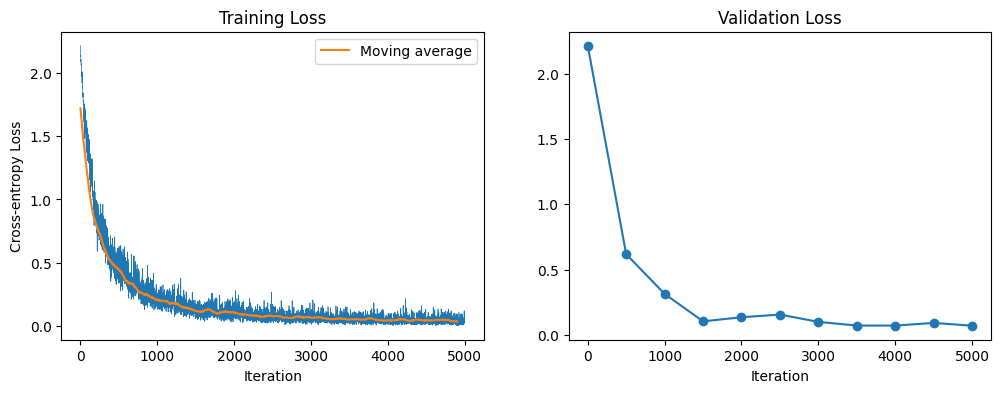

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_transformer_loss(loss_history, val_loss_history):

    # Two horizontal figures side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # First plot = training loss
    ax1.plot(loss_history, lw=0.5)
    # Plot moving average of loss
    window_size = 100
    ax1.plot(np.convolve(loss_history, np.ones(window_size) / window_size, mode='valid'), label='Moving average')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Cross-entropy Loss')
    ax1.set_title('Training Loss')
    ax1.legend()

    # Second plot = validation loss
    # Set marker style to be circles at each data point
    indices = np.arange(0, len(val_loss_history) * eval_interval, eval_interval)
    ax2.plot(indices, val_loss_history, marker='o')
    ax2.set_title('Validation Loss')
    ax2.set_xlabel('Iteration')

    plt.show()

plot_transformer_loss(train_loss_history, val_loss_history)